In [1]:
# Step 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Utility functions
def make_gaussian_psf(size, sigma):
    ax = np.arange(-size//2 + 1., size//2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def fft_psf(psf, shape):
    return np.fft.fft2(np.fft.ifftshift(psf), s=shape)

def blur_image_freq(image, psf):
    F = np.fft.fft2(image)
    H = fft_psf(psf, image.shape)
    G = F * H
    return np.real(np.fft.ifft2(G))

def add_gaussian_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    return image + noise, sigma**2

def inverse_filter(degraded, psf, eps=1e-3):
    G = np.fft.fft2(degraded)
    H = fft_psf(psf, degraded.shape)
    H_safe = np.where(np.abs(H) < eps, eps, H)
    F_hat = G / H_safe
    return np.real(np.fft.ifft2(F_hat))

def wiener_filter(degraded, psf, K):
    G = np.fft.fft2(degraded)
    H = fft_psf(psf, degraded.shape)
    H_conj = np.conj(H)
    W = H_conj / (np.abs(H)**2 + K)
    F_hat = W * G
    return np.real(np.fft.ifft2(F_hat))

def compute_metrics(clean, recon):
    return psnr(clean, recon, data_range=1.0), ssim(clean, recon, data_range=1.0)


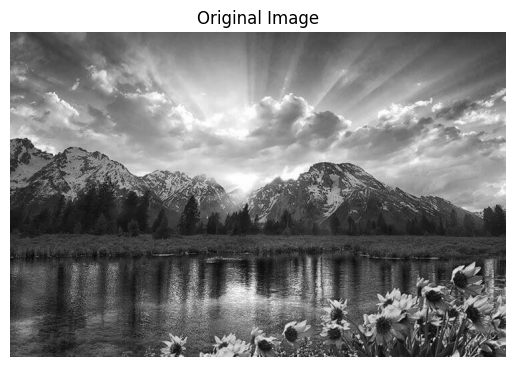

In [2]:
# Step 2: Load image from file (change path here)
orig = img_as_float(io.imread("D:\FDIP research paper\landscape.jpg", as_gray=True))

plt.imshow(orig, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()


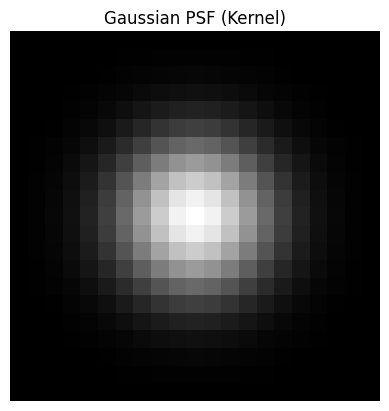

In [3]:
# Step 3: Create PSF (blurring kernel)
psf_size, psf_sigma = 21, 3.0
psf = make_gaussian_psf(psf_size, psf_sigma)

plt.imshow(psf, cmap="gray")
plt.title("Gaussian PSF (Kernel)")
plt.axis("off")
plt.show()


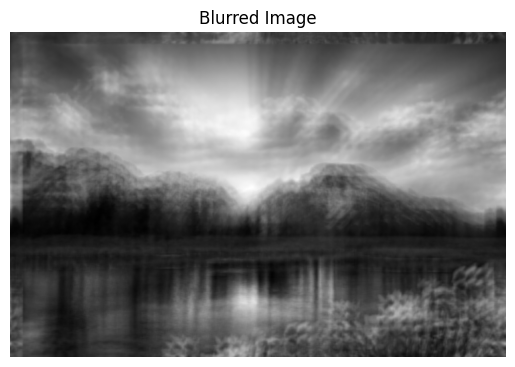

In [4]:
# Step 4: Blur the image
blurred = blur_image_freq(orig, psf)

plt.imshow(blurred, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")
plt.show()


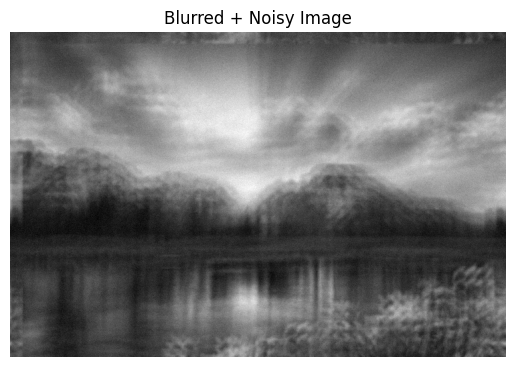

In [5]:
# Step 5: Add Gaussian noise
noisy, noise_var = add_gaussian_noise(blurred, sigma=0.02)

plt.imshow(noisy, cmap="gray")
plt.title("Blurred + Noisy Image")
plt.axis("off")
plt.show()


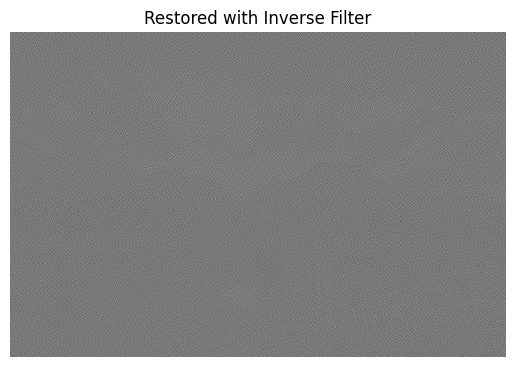

In [6]:
# Step 6: Apply Inverse Filter
inv_restored = inverse_filter(noisy, psf, eps=1e-3)

plt.imshow(inv_restored, cmap="gray")
plt.title("Restored with Inverse Filter")
plt.axis("off")
plt.show()


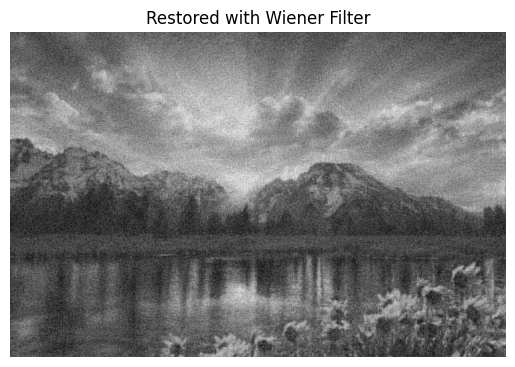

In [7]:
# Step 7: Apply Wiener Filter
signal_var = np.var(orig)
K = noise_var / (signal_var + 1e-12)
wiener_restored = wiener_filter(noisy, psf, K)

plt.imshow(wiener_restored, cmap="gray")
plt.title("Restored with Wiener Filter")
plt.axis("off")
plt.show()


In [8]:
# Step 8: Compare Metrics
p_noisy, s_noisy = compute_metrics(orig, np.clip(noisy, 0, 1))
p_inv, s_inv = compute_metrics(orig, np.clip(inv_restored, 0, 1))
p_wien, s_wien = compute_metrics(orig, np.clip(wiener_restored, 0, 1))

print("PSNR / SSIM Results")
print(f"Noisy:    {p_noisy:.2f} dB, SSIM={s_noisy:.4f}")
print(f"Inverse:  {p_inv:.2f} dB, SSIM={s_inv:.4f}")
print(f"Wiener:   {p_wien:.2f} dB, SSIM={s_wien:.4f}")


PSNR / SSIM Results
Noisy:    18.86 dB, SSIM=0.3950
Inverse:  5.42 dB, SSIM=0.0061
Wiener:   21.57 dB, SSIM=0.3702
